In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

# Setup

We're going to download the collected works of Nietzsche to use as our data for this class.

In [2]:
!mkdir 'data/nietzsche'

In [2]:
PATH='data/nietzsche/'

In [3]:
get_data("https://s3.amazonaws.com/text-datasets/nietzsche.txt", f'{PATH}nietzsche.txt')
text = open(f'{PATH}nietzsche.txt').read()
print('corpus length:', len(text))

corpus length: 600893


In [5]:
text[:400]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unskilled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself '

In [4]:
# set() - unordered collection of unique elements
# sorted() - converts iterable to list in ascending order
chars = sorted(set(text))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 85


Sometimes it's useful to have a zero value in the dataset, e.g. for padding

In [5]:
chars.insert(0, "\0")

''.join(chars)

'\x00\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyzÆäæéë'

Map from chars to indices and back again

In [5]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

*idx* will be the data we use from now own - it simply converts all the characters to their index (based on the mapping above)

In [6]:
idx = [char_indices[c] for c in text]

idx[:10]

[39, 41, 28, 29, 24, 26, 28, 0, 0, 0]

In [21]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

# Three char model

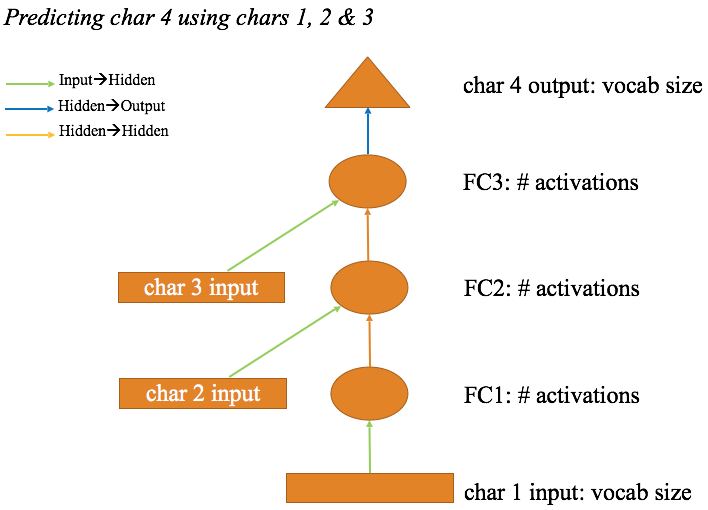

The above arrows of the same color are conceptually similar to a convolutional filter
 - special dot product w/ shared weights

### Create inputs

Create lists of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [25]:
cs=3 # step value
c1_dat = [idx[i]   for i in range(0, len(idx)-cs, cs)] # start at 0
c2_dat = [idx[i+1] for i in range(0, len(idx)-cs, cs)] # start at 1
c3_dat = [idx[i+2] for i in range(0, len(idx)-cs, cs)] # start at 2
c4_dat = [idx[i+3] for i in range(0, len(idx)-cs, cs)] # start at 3

Our inputs

In [29]:
x1 = np.stack(c1_dat)
x2 = np.stack(c2_dat)
x3 = np.stack(c3_dat)

Our output

In [31]:
y = np.stack(c4_dat)

The first 4 inputs and outputs

In [32]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

In [33]:
y[:4]

array([30, 29,  1, 40])

In [35]:
x1.shape, y.shape

((200297,), (200297,))

### Create and train model

Pick a size for our hidden state

In [52]:
n_hidden = 256

The number of latent factors to create (i.e. the size of the embedding matrix)

In [53]:
n_fac = 42

In [44]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        
        # 85 -> 42  (85x42 tensor)
        self.e = nn.Embedding(vocab_size, n_fac)

        # The 'green arrow' from our diagram - the layer operation from input to hidden
        # 42 -> 256  (256x42 tensor)
        self.l_in = nn.Linear(n_fac, n_hidden)

        # The 'orange arrow' from our diagram - the layer operation from hidden to hidden
        # 256 -> 256  (256x256 tensor)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        
        # The 'blue arrow' from our diagram - the layer operation from hidden to output
        # 256 -> 85  (85x256 tensor)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        # pass each char through embedding, linear, and relu to get the input activation values
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        # create a zeroed tensor to which we can add all of the activations to
        h = V(torch.zeros(in1.size()).cuda())
        
        # add each char input activation to previous (or zeros)
        # and pass through hidden layer to get next layer activations
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        # hyperbolic tan - offset sigmoid (0 centered)
        # activation function common in hidden -> hidden transition weight matrices (+maintains negative values???)
        # replaced by Relu generally (6x accelerated convergence)
        
        # run our output layer through a softmax to return next char
        return F.log_softmax(self.l_out(h))

In [39]:
np.stack([x1,x2,x3], axis=1)

array([[40, 42, 29],
       [30, 25, 27],
       [29,  1,  1],
       ...,
       [72, 62, 67],
       [59, 74, 65],
       [67, 58, 72]])

In [40]:
# use data loaders from fast.ai
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

In [41]:
m = Char3Model(vocab_size, n_fac).cuda()

In [42]:
# iterator
it = iter(md.trn_dl)

# call next on iterator to get a minibatch - xs(3) and y(tensor)
*xs,yt = next(it)

# use model as a function by passing variable versions of xs
t = m(*V(xs))

In [61]:
t  # each row is a probability of a char being one of the 85 chars in our vocab

Variable containing:
-4.6428 -4.5424 -4.3666  ...  -4.4854 -4.4305 -4.4196
-4.5789 -4.3436 -4.6017  ...  -4.5656 -4.2452 -4.5772
-4.6951 -4.4566 -4.2675  ...  -4.5146 -4.4309 -4.5179
          ...             ⋱             ...          
-4.4200 -4.5115 -4.2925  ...  -4.5013 -4.2891 -4.2265
-4.6007 -4.3931 -4.3331  ...  -4.4218 -4.3016 -4.5173
-4.5305 -4.3467 -4.3182  ...  -4.2803 -4.4642 -4.3354
[torch.cuda.FloatTensor of size 512x85 (GPU 0)]

In [64]:
m.parameters

<bound method Module.parameters of Char3Model(
  (e): Embedding(85, 42)
  (l_in): Linear(in_features=42, out_features=256)
  (l_hidden): Linear(in_features=256, out_features=256)
  (l_out): Linear(in_features=256, out_features=85)
)>

In [66]:
# use optimizer, m.parameters() returns a list of things to optimize
opt = optim.Adam(m.parameters(), 1e-2)

In [67]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.107564   1.091672  



[1.0916724]

In [68]:
set_lrs(opt, 0.001)

In [69]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.852892   0.730979  



[0.73097944]

### Test model

In [70]:
def get_next(inp):
    # get a tensor (array of indices for each char in the input)
    idxs = T(np.array([char_indices[c] for c in inp]))
    
    # pass tensor to model function as a variable; returns array of probabilities (p)
    p = m(*VV(idxs))
    
    # get expected char index from output array (p) by returning the maximum
    i = np.argmax(to_np(p))
    
    # return char from char index
    return chars[i]

In [71]:
get_next('y. ')

'T'

In [72]:
get_next('ppl')

'e'

In [73]:
get_next(' th')

'e'

In [74]:
get_next('and')

' '

# Our first RNN!

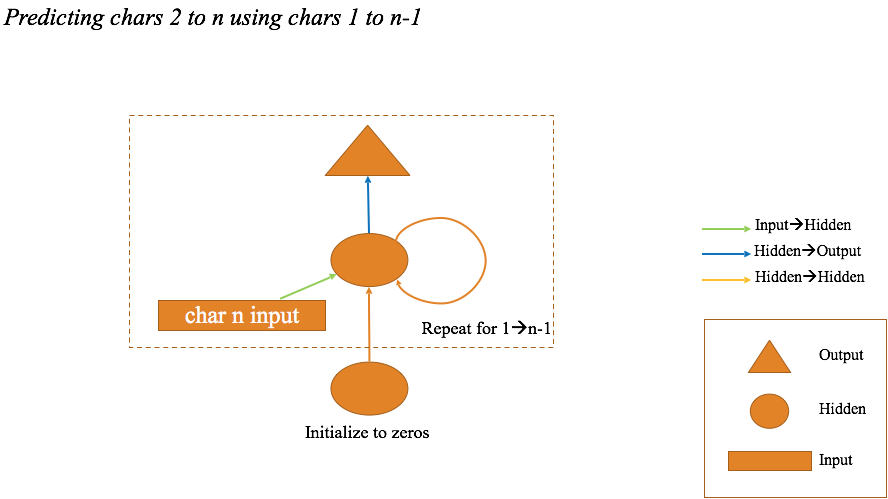

### Create inputs

This is the size of our unrolled RNN.

In [7]:
cs=8

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to out model.

In [10]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs)]

Then create a list of the next character in each of these series. This will be the labels for our model.

In [11]:
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs)]

In [28]:
xs = np.stack(c_in_dat, axis=0)

In [29]:
xs.shape

(600885, 8)

In [31]:
y = np.stack(c_out_dat)

So each column below is one series of 8 characters from the text.

In [36]:
xs[:cs,:cs]
# [0..8]
# [1..9]
# [2..10]
# these are all overlapping lists

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])

...and this is the next character after each sequence.

In [70]:
y[:cs]

array([ 1,  1, 43, 45, 40, 40, 39, 43])

### Create and train model

In [41]:
val_idx = get_cv_idxs(len(idx)-cs-1)
print(f'{len(idx) // len(val_idx)}% of data')

5% of data


In [42]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [50]:
class CharLoopModel(nn.Module):
    # This is an RNN!
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        
        # same as above model
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [54]:
m = CharLoopModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [55]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.050951   2.060041  



[2.0600412]

In [56]:
set_lrs(opt, 0.001)

In [57]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.805152   1.80136   



[1.8013605]

### Concat rather than add input activations and hidden activations

input state (inp) and hidden state (h) are qualitatively different;
adding them up could result in the loss of information

In [58]:
# Same as above but use .cat instead of +

class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        
        # this needs to be changed to maintain proper dimensionality if we're concatenating instead of vector addition
        self.l_in = nn.Linear(n_fac+n_hidden, n_hidden)
        
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            # above version for comparison
            # inp = F.relu(self.l_in(self.e(c)))
            # h = F.tanh(self.l_hidden(h+inp))
            
            # this is now of the size n_fac + n_hidden
            inp = torch.cat((h, self.e(c)), 1)
            # this converts it back to the size of n_hidden
            inp = F.relu(self.l_in(inp))
            # putting it through same square matrix as before; same size of n_hidden
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [59]:
m = CharLoopConcatModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [94]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [60]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.802063   1.769705  



[1.7697047]

In [61]:
set_lrs(opt, 1e-4)

In [62]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.681223   1.68614   



[1.6861398]

### Test model

In [63]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [64]:
get_next('for thos')

'e'

In [65]:
get_next('part of ')

't'

In [66]:
get_next('queens a')

'n'

# RNN with pytorch

In [67]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        # Note: this is a rank 2 tensor which allows for bi-directional or multilayer RNNs
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [68]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [110]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [111]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([8, 512, 42])

In [112]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([8, 512, 256]), torch.Size([1, 512, 256]))

In [113]:
t = m(*V(xs)); t.size()

torch.Size([512, 85])

In [69]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.867331   1.84944   
    1      1.674149   1.669166                              
    2      1.590652   1.597895                              
    3      1.533335   1.551213                              



[1.5512134]

In [70]:
set_lrs(opt, 1e-4)

In [71]:
fit(m, md, 2, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.464457   1.511275  
    1      1.462303   1.505767                              



[1.5057666]

### Test model

In [72]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [73]:
get_next('for thos')

'e'

In [74]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [75]:
get_next_n('for thos', 40)

'for those of the same the sense of the same the '

## Multi-output model

### Setup

Let's take non-overlapping sets of characters this time

In [76]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]

Then create the exact same thing, offset by 1, as our labels

In [77]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

In [78]:
xs = np.stack(c_in_dat)
xs.shape

(75111, 8)

In [79]:
ys = np.stack(c_out_dat)
ys.shape

(75111, 8)

In [80]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [33, 38, 31,  2, 73, 61, 54, 73],
       [ 2, 44, 71, 74, 73, 61,  2, 62],
       [72,  2, 54,  2, 76, 68, 66, 54],
       [67,  9,  9, 76, 61, 54, 73,  2],
       [73, 61, 58, 67, 24,  2, 33, 72],
       [ 2, 73, 61, 58, 71, 58,  2, 67]])

In [81]:
ys[:cs,:cs]

array([[42, 29, 30, 25, 27, 29,  1,  1],
       [ 1, 43, 45, 40, 40, 39, 43, 33],
       [38, 31,  2, 73, 61, 54, 73,  2],
       [44, 71, 74, 73, 61,  2, 62, 72],
       [ 2, 54,  2, 76, 68, 66, 54, 67],
       [ 9,  9, 76, 61, 54, 73,  2, 73],
       [61, 58, 67, 24,  2, 33, 72,  2],
       [73, 61, 58, 71, 58,  2, 67, 68]])

### Create and train model

In [82]:
val_idx = get_cv_idxs(len(xs)-cs-1)

In [83]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [84]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)
    
# There is a problem with this implementation
# every time we call “forward” we are resetting our activation values back to zero.
# We are losing previous activation information. Is there any way to save this information and move it forward?

In [85]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [90]:
it = iter(md.trn_dl)
*xst,yt = next(it)

In [91]:
# original implementation expects 2 minibatches of vectors (2 rank 2 tensors)
# we have a rank 3 tensor: we have 8 time steps of 84 probabilities for 512 items in the minibatch
def nll_loss_seq(inp, targ):
    # input: (8,512,256) tensor
    sl,bs,nh = inp.size()
    # target: (512,8) -> need to transpose
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [92]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.979013   1.96016   
    1      1.932925   1.92313                               
    2      1.893313   1.892619                              
    3      1.866464   1.870324                              



[1.8703244]

In [93]:
set_lrs(opt, 1e-4)

In [94]:
fit(m, md, 1, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.834329   1.857718  



[1.8577179]

### Identity init!

In [95]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [96]:
# Identity matrix: anything multiplied by an identity matrix is itself
# use this to avoid gradient explosion (matrix multiplier increasing/decreasing activations exponentially)
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 256x256 (GPU 0)]

In [97]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.346109   2.174129  
    1      2.083413   2.01179                               
    2      1.975599   1.952156                              
    3      1.914053   1.900017                              



[1.9000174]

In [98]:
set_lrs(opt, 1e-3)

In [99]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.822085   1.839598  
    1      1.81007    1.831413                              
    2      1.800294   1.826273                             
    3      1.792177   1.821154                              



[1.8211542]

## Stateful model

### Setup

In [8]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

PATH='data/nietzsche/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
# need to put last ~20% in val; rest in trn
# head -n -1986 nietzsche.txt > trn.txt
# tail -n -1986 nietzsche.txt > val.txt

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

nietzsche.txt  trn/  val/


In [9]:
# data.Field is a description of how to preprocess the text
# tokenize for character model instead of word model (spacey)
# list('abc') => ['a', 'b', 'c']
# each minibatch is going to contain a list of characters
TEXT = data.Field(lower=True, tokenize=list)

# bs - batch size means split text into 64 batches (not split into batches of length 64)
# bptt - number of layers to backprop through -- effectively number of characters to use in predictions
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

# min_freq -> don't bother with characters appearing less than 3 times...
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)
# adds Text.vocab property

# data loader - number of mini batches (~ tokens/bs/bptt -- bptt (sequence length) gets randomized somewhat by torchtext)
# number of tokens - unique items in vocabulary
#
# number of tokens
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(942, 55, 1, 482972)

### RNN

In [4]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
        # we're now storing our previous activations
        self.init_hidden(bs)
        
    def forward(self, cs):
        # actual batch size
        bs = cs[0].size(0)
        
        # last batch size will be shorter than the rest (remainder of tokens/bs)
        # self.h = tensor (# of activations, minibatch size)
        # if last batch size != actual batch size -> reset to zeros
        if self.h.size(1) != bs: self.init_hidden(bs)
            
        outp,h = self.rnn(self.e(cs), self.h)
        
        # grab tensor (activations) out of the variable and create a new variable - same value but no history of operations
        # stops backpropagation from having to calculate through entire history each epoch
        # bptt - back propagation through time (number of layers to backprop through -- effectively number of characters to use in predictions)
        #   * larger bptt -> the slower/less resilient training becomes (exploding gradients); but you can capture more memory/state
        self.h = repackage_var(h)
        
        # pytorch loss functions don't like receiving rank 3 tensor (3d array)...
        # choose our dimension to run through the softmax (which axis to sum to 1?) - last axis (probabilites per char)
        # need to flatten out our predictions into an array; pytorch does this by default for our y values
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    # called at start and end of each epoch
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [5]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [6]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      1.87281    1.846068  
    1      1.70217    1.707703                               
    2      1.622385   1.629446                               
    3      1.572413   1.595646                               



[1.5956459]

In [8]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      1.497208   1.5601    
    1      1.494818   1.549236                               
    2      1.487449   1.546164                               
    3      1.486939   1.545782                               



[1.5457816]

### RNN loop

In [9]:
# From the pytorch source
# Input state [input data multiplied by weight matrices (and biases) -- linear layer] is added to existing hidden state; tanh normalized
# In practice, this is outdated -> tends toward gradient explosion.  Need small lr and low bptt
def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))
# note: addition rather than concatenation...

In [12]:
# same as above but using explicit loops rather than calling pytorch RNN
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [13]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [8]:
fit(m, md, 4, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.81013  1.7969 ]                                 
[ 1.       1.62515  1.65346]                                 
[ 2.       1.53913  1.58065]                                 
[ 3.       1.48698  1.54217]                                 



### GRU

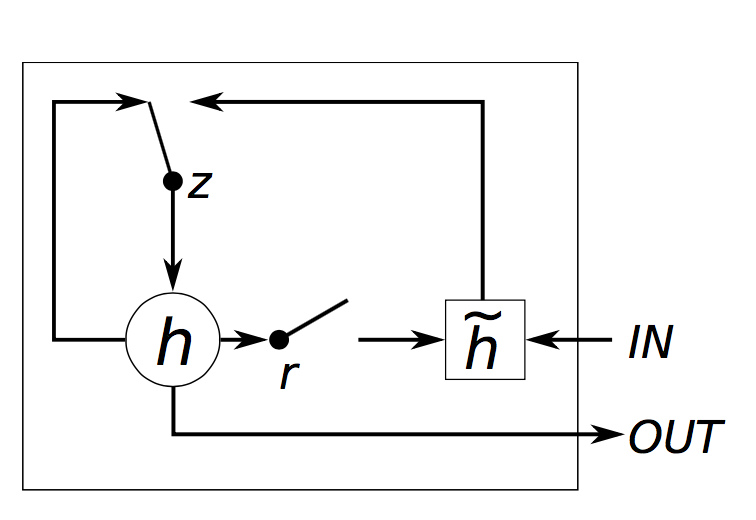

- r,z: mini neural nets (logistic regression) -- sigmoid of matrix product of weights and concatenation of previous hidden state and new input
- operate like logic gates - value between 0 and 1 (hence sigmoid)


- r [reset gate]: determines how much of previous hidden state to remember  (e.g. full stop: throw away hidden state)
- z [update gate]: determines how much of new input hidden state to include


- previous activations are multiplied by r
- incoming activations multiplied by z

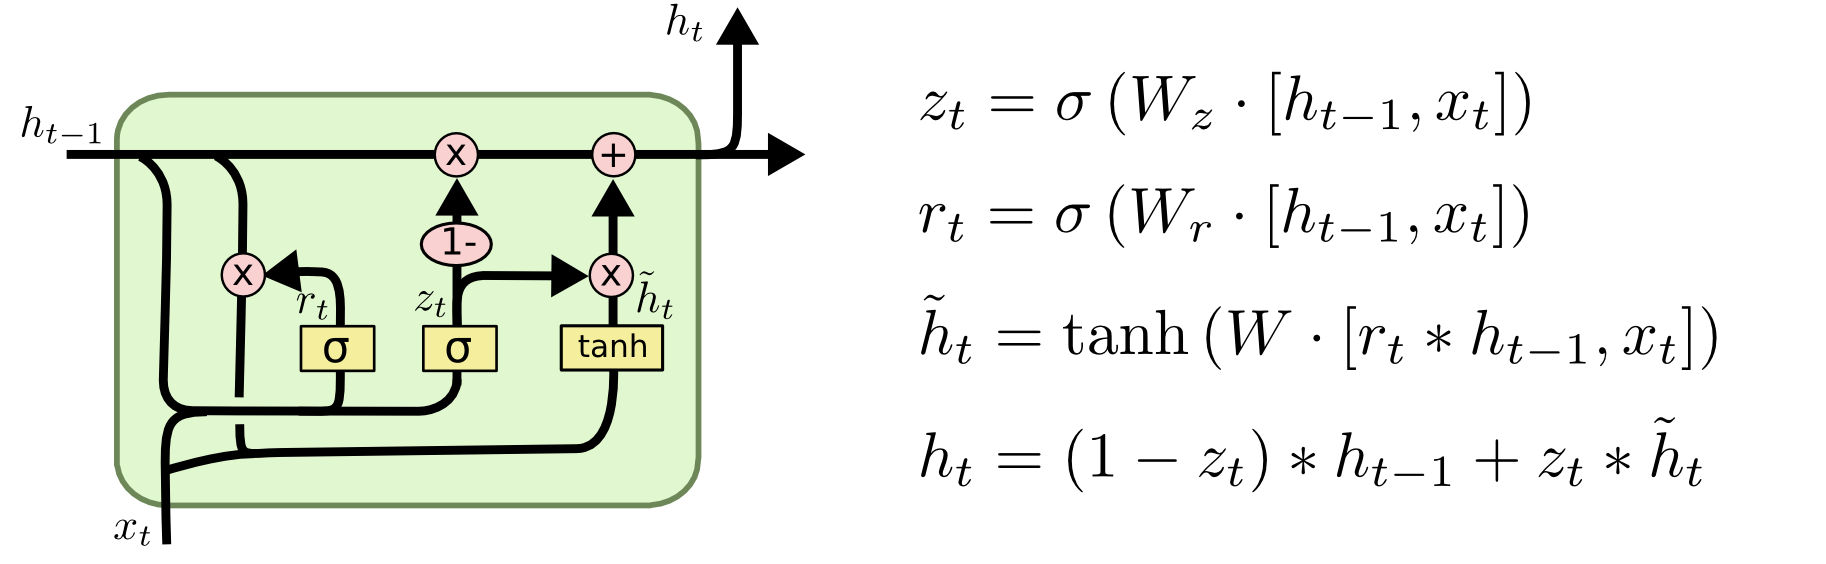

- ht: linear interpolation between two hidden states

In [10]:
# From the pytorch source code - for reference
def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)

In [11]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [12]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [13]:
fit(m, md, 6, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      1.757409   1.738304  
    1      1.580407   1.59052                                
    2      1.499771   1.522112                               
    3      1.449542   1.493234                               
    4      1.408118   1.480025                               
    5      1.378183   1.464306                               



[1.4643064]

In [14]:
set_lrs(opt, 1e-4)

In [15]:
fit(m, md, 3, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      1.283766   1.430277  
    1      1.285572   1.429407                               
    2      1.286977   1.422525                               



[1.4225247]

# Putting it all together: LSTM

In [16]:
# SGDR without using the learner class via callbacks

from fastai import sgdr

n_hidden=512
# added dropout inside RNN (after each time step); doubled size of hidden layer

In [17]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    # LSTM has a cell state in addition to a hidden state so need to return a tuple of matrices
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [18]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()     # pytorch model

# if not using the learner class we need to explicitly specify a LayerOptimizer (fastai expects this) instead of:
# opt = optim.Adam(m.parameters(), 1e-3)           # pytorch optimizer
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)     # fastai layer optimizer - diff learning rates/diff weight decay

In [19]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [20]:
fit(m, md, 2, lo.opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.867113   1.774472  
    1      1.746096   1.661795                              



[1.6617954]

In [21]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
# callback: saves model

cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
# this requires layer optimizer

# pass in optimizer and callbacks
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.568684   1.520393  
    1      1.614172   1.543942                              
    2      1.493487   1.456831                              
    3      1.627404   1.56023                               
    4      1.556537   1.49245                               
    5      1.467149   1.435586                              
    6      1.407435   1.406164                              
    7      1.606384   1.524531                              
    8      1.573028   1.512815                              
    9      1.538323   1.489955                              
    10     1.501997   1.454865                              
    11     1.4592     1.426531                              
    12     1.410372   1.401554                              
    13     1.377534   1.376817                              
    14     1.344764   1.365674                              



[1.365674]

In [22]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**5-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.333671   1.359168  
    1      1.338206   1.361306                              
    2      1.337495   1.362975                              
    3      1.340652   1.355471                              
    4      1.324156   1.353165                              
    5      1.324131   1.355594                              
    6      1.325153   1.355667                              
    7      1.321904   1.3523                                
    8      1.321813   1.347622                              
    9      1.312891   1.347044                              
    10     1.304628   1.342866                              
    11     1.300249   1.345528                              
    12     1.294555   1.345661                              
    13     1.297734   1.341812                              
    14     1.290834   1.342663                              
    15     1.294007   1.348338                      

[1.3331424]

### Test

In [23]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [24]:
get_next('for thos')

'e'

In [25]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [26]:
print(get_next_n('for thos', 400))

for those releg theindividualforth it isliped, whichtheastities, is than a schopenhauer will, and concerning and aside called" in myself,the type of evadicte humanitament, morality; in which level, and desible to love be uncomeand senses used to be thepracter up itself. when all oursimilatism--but german life, as of reachevils--glanzy it. one will to have owedlesss error to theoriginating in an european i


In [27]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**5-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.228192   1.333435  
    1      1.230596   1.332723                              
    2      1.225053   1.330392                              
    3      1.231201   1.332471                              
    4      1.229654   1.332695                              
    5      1.225113   1.337672                              
    6      1.230945   1.337703                              
    7      1.225447   1.334448                              
    8      1.228756   1.329856                              
    9      1.227008   1.334463                              
    10     1.224854   1.333234                              
    11     1.226061   1.337947                              
    12     1.229674   1.330706                              
    13     1.22561    1.330682                              
    14     1.228557   1.332297                              
    15     1.227604   1.331556                      

[1.3281977]

In [28]:
print(get_next_n('for thos', 400))

for those in the philosopher...120. otherwishness andmascustom: harshelly; what at it, what has bad as would not a belong tosensities of questioned and that the tempt of  fact," one at passing a newknowledge into the higher self-paposing that said  expire, his sake thesan felt, to a malignical case cave; woman say and almost granted most scholarily, would use out of theeffected out!85. it he dispearment, 
